# Medical Image Preprocessing

This notebook is the very first step of my master's thesis. The goal is to make me familiar with the common preprocessing techniques for medical images.
This notebook could also be considered as my learning diary which records my learning journey.

The dataset applied here is LIDC-IDRI, which is a public dataset for lung cancer detection. The dataset is publicly available at https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI.

Reading Materials:
- Medical Image Preprocessing: https://se.mathworks.com/help/medical-imaging/ug/overview-medical-image-preprocessing.html
- Quick guide on radiology image pre-processing for deep learning applications in prostate cancer research: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7790158/
- Preparing CT imaging datasets for deep learning in lung nodule analysis: Insights from four well-known datasets: https://www-sciencedirect-com.ep.fjernadgang.kb.dk/science/article/pii/S2405844023043128
- Medical Images in Python (Computed Tomography): https://vincentblog.xyz/posts/medical-images-in-python-computed-tomography
- Design of lung nodules segmentation and recognition algorithm based on deep learning: https://www.researchgate.net/publication/356015151_Design_of_lung_nodules_segmentation_and_recognition_algorithm_based_on_deep_learning
- 3D Medical Imaging Preprocessing All You Need: https://github.com/fitushar/3D-Medical-Imaging-Preprocessing-All-you-need
- Denoising diffusion probabilistic models for 3D medical image generation: https://www.nature.com/articles/s41598-023-34341-2
- Understanding coordinate systems and DICOM for deep learning medical image analysis: https://theaisummer.com/medical-image-coordinates/
- Automatic detection of the pulmonary nodules from CT images: https://www.researchgate.net/publication/306033192_Automatic_detection_of_the_pulmonary_nodules_from_CT_images
- DICOM Standard Browser: https://dicom.innolitics.com/ciods/digital-x-ray-image/dx-image/00281050
- Pulmonary Benign Ground-Glass Nodules: CT Features and Pathological Findings: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7930605/
- Chest computed tomography display preferences. Survey of thoracic radiologists: https://pubmed.ncbi.nlm.nih.gov/8537208/
- Volumentations: https://github.com/ZFTurbo/volumentations

Pylidc library is used here.

In [1]:
import numpy as np
import pandas as pd
import pylidc as pl
import pydicom as dcm
import SimpleITK as sitk
import matplotlib.pyplot as plt

## Background Removal

This part involves segmenting the region of interest from the image background.

One example could be skull stripping, which removes the skull and other background regions from MRI images of the brain.

The way how to do typically consists of applying a mask of the region of interest (ROI) that you create using morphological operations or other segmentation thechniques.

Therefore, **mask information** is needed to perform.

*Multiply the mask image and the original image.*

<font color=red>***No Need**:*</font> In my project, it is unnessary to do this, since what I pursue is to input the raw images without any hand-crafted features, for example, the mask.

## Denoising

Medical imaging modalities are susceptible to noise, which introduces random intensity fluctuations in an image.

There are several sources of disturbance in CT images, which mainly include beam hardening, patient movements, scanner malfunction, low resolution, intrinsic low dose radiation, and metal implants.
Each of these disturbances is addressed individually in the literature below.
- Zhang Y., et al., “<a href='https://www.sciencedirect.com/science/article/pii/S0360301606032081?casa_token=PdAGu03IQ3IAAAAA:IRdN081eWJE8UrFMA0593K4zYiSKTu0Ugb8siPafnyPg0Gh-XerfpNemBQCQ1cVUTUC1W31t'>Reducing metal artifacts in cone-beam CT images by preprocessing projection data</a>,” Int. J. Radiat. Oncol. Biol. Phys. 67(3), 924–932 (2007). 10.1016/j.ijrobp.2006.09.045
- Patil S., Udupi V. R., “<a href=https://svv-research-data.s3.ap-south-1.amazonaws.com/160129-Paper%201_Preprocessing%20To%20Be%20Considered%20For%20MR%20and%20CT%20Images%20Containing%20Tumors_IOSRJEEE_B31E0d01.pdf>Preprocessing to be considered for MR and CT images containing tumors</a>,” IOSR J. Electr. Electron. Eng. 1(4), 54–57 (2012). 10.9790/1676-0145457

To reduce noise, filter images in the spatial and frequency domains. 

However, this seems not to be a must-do step in my project, since there is no related literature and github repo that mentions the necessity of denoising in the preprocessing of LIDC-IDRI dataset.

<font color=red>***Question**: Should I do denoising?*</font>

## Resampling / CT Data Interpolation

There is a preference to have equal physical spacing for the input images. 

Maintaining the same resolution is desired to avoid center-specific or reconstruction-dependent findings.

Images are usually interpolated in the $xy$ plane and/or in $z$ direction based on the desired physical spacing or ultimate number of voxels.

Function `ResampleImageFilter()` from the SimpleITK library will help.

Normally, cubic-spline and B-spline are generally better convolving functions to resample images as they perform close to an ideal low-pass filter.

---

Use resampling to change the pixel or voxel size of an image without changing its spatial limits in the patient coordinate system ==> Change voxels to uniform size.

Resampling is useful for standarding image resolution across a dataset that contains images from multiple scanners.

And this is performed to achieve consistent voxel size across different CT scans.

When acquiring CT images from different scanners, variations in pixel size and slice thickness can occur, leading to increased variability in the features of two-dimensional (2D) images or three-dimensional (3D) volumes.

The spacing can be determined based on the desired voxel size for the specific task or the input requirement of the deep learning model.

---

**LIDC-IDRI**

Slice thicknesses were 0.6 mm (n=7), 0.75 mm (n=30), 0.9 mm (n=2), 1.0 mm (n=58), 1.25 mm (n=349), 1.5 mm (n=5), 2.0 mm (n=124), 2.5 mm (n=322), 3.0 mm (n=117), 4.0 mm (n=1), and 5.0 mm (n=3). Reconstruction interval ranged from 0.45 to 5.0 mm (mean: 1.74 mm). The in-plane pixel size ranged from 0.461 to 0.977 mm (mean: 0.688 mm). 

<font color=red>***Question**: Which spacing should I choose?*</font>

In the paper "Design of lung nodules segmentation and recognition algorithm based on deep learning", the authors stated that the common voxel spacing is 3.0 mm × 1.5 mm × 1.5 mm. However, I doubt on it.

**There is another paper, "Denoising diffusion probabilistic models for 3D medical image generation" limits the resolution of 128 × 128 × 128 voxel, and I am going to follow this. Below is the way how it is performed.**

<u>*The LIDC were resampled to a standard voxel spacing of 1 mm in all dimensions. Subsequently, the pixel values were converted to Hounsfield units and the images were center-cropped to dimensions of 320 × 320 × 320 voxels before being resized to 128 × 128 × 128 voxels. Images from all datasets were min–max normalized to the range of − 1 to 1.*</u>

---
**The post from AI Summer, "*It is possible to resample to a bigger voxel size to reduce the size of the medical image. This can be understood as a downsampling operation of a signal*."** This post also provides a practice about how to perform affine transformation to move from one modality to another. ==> https://theaisummer.com/medical-image-coordinates/

In [2]:
standard_voxel_spacing = [1.0, 1.0, 1.0]

# read ct by using simpleitk and modify to get window center and width and rescale intercept and slope
def read_ct_scan2sitk(patient_id):
    patient = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).first()
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(patient.get_path_to_dicom_files())
    reader.SetFileNames(dicom_names)
    
    # header to retrieve basic info
    header = dcm.read_file(dicom_names[0])
    window_center = header.WindowCenter
    window_width = header.WindowWidth
    rescale_intercept = header.RescaleIntercept
    rescale_slope = header.RescaleSlope
    
    return reader.Execute(), window_center, window_width, rescale_intercept, rescale_slope

# reference: 3D Medical Imaging Preprocessing All You Need
def resample_img(itk_image, out_spacing=[1.0, 1.0, 1.0], is_label=False):
    # resample images to 2mm spacing with simple itk

    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

***<font color=red>Question:</font>*** *Apply resample only ensures the same voxel size, but does not ensure the same shape?*

What is voxel size, shape, and resolution?
- Size: The size of the voxel in the x, y, and z directions.
- Shape: The number of voxels in the x, y, and z directions.
- Resolution: The size of the voxel in the x, y, and z directions and the number of voxels in the x, y, and z directions.

Therefore, my understanding is that resampling is to ensure the same voxel size in terms of physical by using data interpolation, while the shape of the image is not changed.
However, data interpolation is also the technique to ensure the same shape of images.

### Verification

Verified that the resampling operation is to ensure the same voxel size and shape of the image.

In [3]:
pid1 = 'LIDC-IDRI-0001'
pid2 = 'LIDC-IDRI-0002'
pid3 = 'LIDC-IDRI-0003'
pid4 = 'LIDC-IDRI-1002'

img1, wc1, wl1, ri1, rs1 = read_ct_scan2sitk(pid1)
img2, wc2, wl2, ri2, rs2 = read_ct_scan2sitk(pid2)
img3, wc3, wl3, ri3, rs3 = read_ct_scan2sitk(pid3)
img4, wc4, wl4, ri4, rs4 = read_ct_scan2sitk(pid4)

img1_resampled = resample_img(img1, standard_voxel_spacing)
img2_resampled = resample_img(img2, standard_voxel_spacing)
img3_resampled = resample_img(img3, standard_voxel_spacing)
img4_resampled = resample_img(img4, standard_voxel_spacing)

shape1 = sitk.GetArrayFromImage(img1_resampled).shape
shape2 = sitk.GetArrayFromImage(img2_resampled).shape
shape3 = sitk.GetArrayFromImage(img3_resampled).shape
shape4 = sitk.GetArrayFromImage(img4_resampled).shape

print(shape1, shape2, shape3)
print(wc1, wl1, ri1, rs1)
print(wc2, wl2, ri2, rs2)
print(wc3, wl3, ri3, rs3)
print(wc4, wl4, ri4, rs4)

(332, 360, 360) (326, 349, 349) (350, 420, 420)
-600 1600 -1024 1
40 350 -1024 1
-600 1600 -1024 1
[-0450, -0450] [02000, 02000] -1000 1


## Lung HU / Windowing in CT Data

**Hounsefield Unit (HU)**, which is the average of all the attenuation values contained within the corresponding voxel. 

This CT Number is compared to the attenuation value of the water and displayed on a scale named Hounsfield units. 

On this scale, the water has an attenuation value of zero and the range of CT numbers could be up to 4000. 

Each number represents a shade of grey, this means that we could have up to 4000 shades of grey. ==> Lung HU range: $[-700, -600]$. Wikipedia (https://en.wikipedia.org/wiki/Hounsfield_scale)

In the paper, Automatic detection of the pulmonary nodules from CT images, it states that,

The pixel values are converted to Hounsfield units (HU) by using equation $\text{HU} = \text{Pixel value} \times \text{slope} + \text{intercept}$ and these two parameters are provided in the DICOM header.

Update: By Meeting on April 17, my supervisor suggested me to consider using the air HU value which is -1000, and the bone HU value which is 1000, and this window covers the whole interesting tissues, and the soft tissue somehow will be zero.

In [4]:
# reference: https://vincentblog.xyz/posts/medical-images-in-python-computed-tomography
def transform_to_hu(intercept, slope, single_slice):
    hu_slice = single_slice * slope + intercept
    return hu_slice

def window_image(single_slice, window_center, window_width): 
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = single_slice.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max

    return window_image

### Visualization

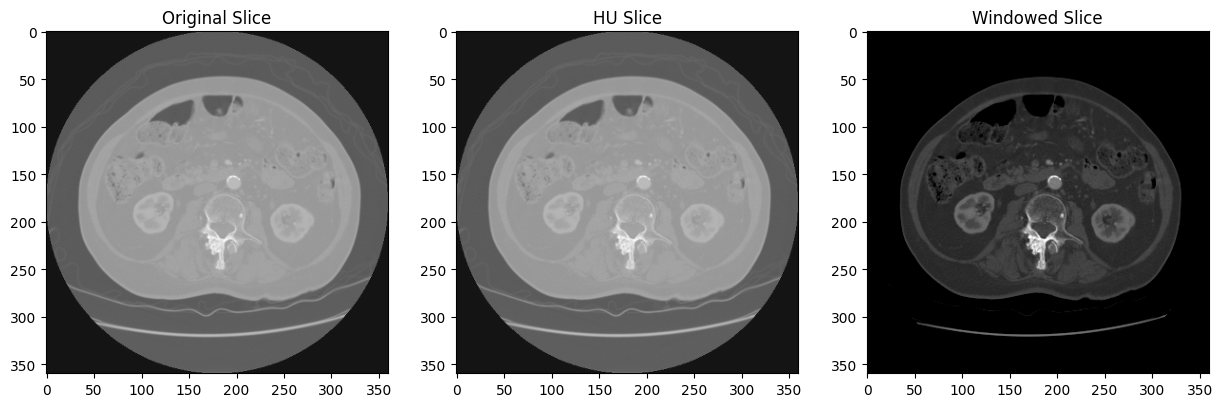

(326, 349, 349)
40 350 -1024 1


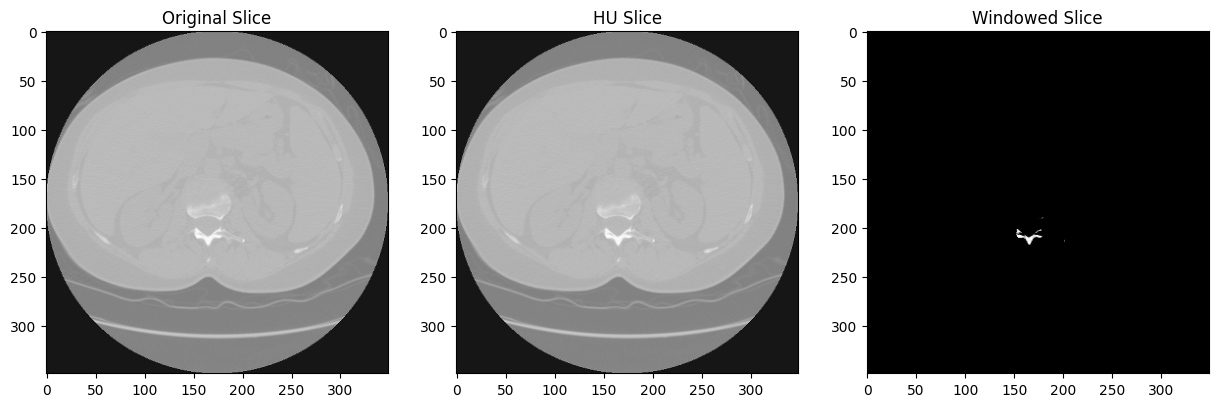

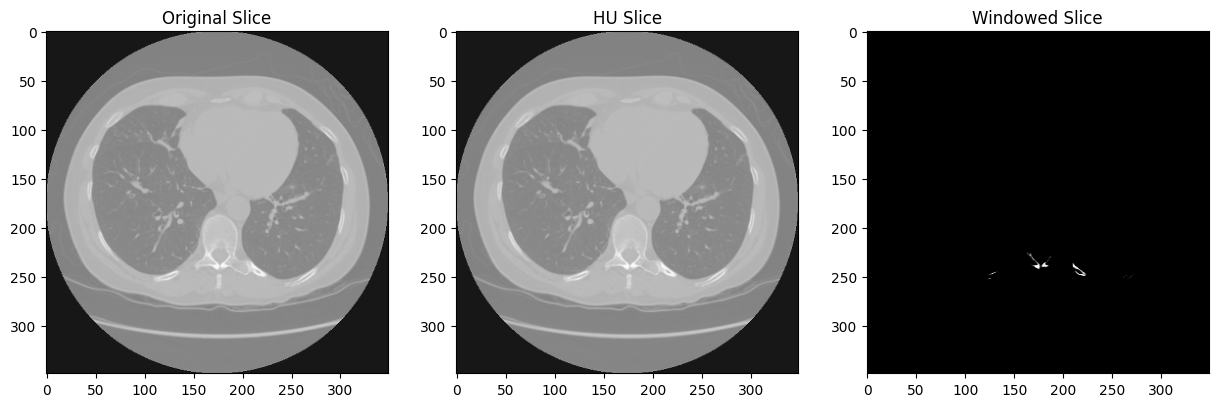

In [162]:
# above is for a single slice, now we will do the same for the whole volume
# get the first slice of the volume from img1
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

slice1 = sitk.GetArrayFromImage(img1_resampled)[0]
ax[0].imshow(slice1, cmap='gray')
ax[0].set_title('Original Slice')

apply_window1 = transform_to_hu(ri1, rs1, slice1)
ax[1].imshow(apply_window1, cmap='gray')
ax[1].set_title('HU Slice')

# apply windowing to the first slice
windowed1 = window_image(apply_window1, wc1, wl1)
ax[2].imshow(windowed1, cmap='gray')
ax[2].set_title('Windowed Slice')

plt.show()

# pid 0002
pid = 'LIDC-IDRI-0002'
img, wc, wl, ri, rs = read_ct_scan2sitk(pid)
img_resampled = resample_img(img, standard_voxel_spacing)
shape = sitk.GetArrayFromImage(img_resampled).shape
print(shape)
print(wc, wl, ri, rs)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

_slice = sitk.GetArrayFromImage(img_resampled)[0]
ax[0].imshow(_slice, cmap='gray')
ax[0].set_title('Original Slice')

apply_window = transform_to_hu(ri, rs, _slice)
ax[1].imshow(apply_window, cmap='gray')
ax[1].set_title('HU Slice')

# apply windowing to the first slice
windowed = window_image(apply_window, wc, wl)
ax[2].imshow(windowed, cmap='gray')
ax[2].set_title('Windowed Slice')

plt.show()

_slice2 = sitk.GetArrayFromImage(img_resampled)[100]
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(_slice2, cmap='gray')
ax[0].set_title('Original Slice')

apply_window2 = transform_to_hu(ri, rs, _slice2)
ax[1].imshow(apply_window2, cmap='gray')
ax[1].set_title('HU Slice')

# apply windowing to the first slice
windowed2 = window_image(apply_window2, wc, wl)
ax[2].imshow(windowed2, cmap='gray')
ax[2].set_title('Windowed Slice')

plt.show()

### Exploration for 3D

<font color=red>***Question**: This is for each single image, but what about the whole volume?*</font>

To explore it, I am going to see, for one 3DCT, whether the basic info (e.g., slope, intercept, window center and window level) is the same for all slices.

***By experiments, the basic information, such as slope, intercept, window center, and window level, is the same for all slices in one 3DCT.***

In [158]:
pid = 'LIDC-IDRI-1002'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
dcm_files = scan.load_all_dicom_images()
# see whether the wc and wl and ri and rs are same
same = True
first_wc = dcm_files[0].WindowCenter
first_wl = dcm_files[0].WindowWidth
first_ri = dcm_files[0].RescaleIntercept
first_rs = dcm_files[0].RescaleSlope

for i in range(len(dcm_files)):
    header = dcm_files[i]
    wc = header.WindowCenter
    wl = header.WindowWidth
    ri = header.RescaleIntercept
    rs = header.RescaleSlope
    print(wc, wl, ri, rs)
    if wc != first_wc or wl != first_wl or ri != first_ri or rs != first_rs:
        same = False
        break
    
print(same) # true means all the same

Loading dicom files ... This may take a moment.
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-0450, -0450] [02000, 02000] -1000 1
[-

In [191]:
# check the first 100 patients what wc and wl and ri and rs they have 
for i in range(100):
    pid = 'LIDC-IDRI-{:04d}'.format(i+1)
    img, wc, wl, ri, rs = read_ct_scan2sitk(pid)
    print('pid: {} ==> wc: {}, wl: {}, ri: {}, rs: {}'.format(pid, wc, wl, ri, rs))

pid: LIDC-IDRI-0001 ==> wc: -600, wl: 1600, ri: -1024, rs: 1
pid: LIDC-IDRI-0002 ==> wc: 40, wl: 350, ri: -1024, rs: 1
pid: LIDC-IDRI-0003 ==> wc: -600, wl: 1600, ri: -1024, rs: 1
pid: LIDC-IDRI-0004 ==> wc: 40, wl: 400, ri: -1024, rs: 1
pid: LIDC-IDRI-0005 ==> wc: -600, wl: 1600, ri: -1024, rs: 1
pid: LIDC-IDRI-0006 ==> wc: -600, wl: 1600, ri: -1024, rs: 1
pid: LIDC-IDRI-0007 ==> wc: 40, wl: 400, ri: -1024, rs: 1
pid: LIDC-IDRI-0008 ==> wc: -600, wl: 1600, ri: -1024, rs: 1
pid: LIDC-IDRI-0009 ==> wc: 40, wl: 400, ri: -1024, rs: 1
pid: LIDC-IDRI-0010 ==> wc: 40, wl: 350, ri: -1024, rs: 1
pid: LIDC-IDRI-0011 ==> wc: -600, wl: 1600, ri: -1024, rs: 1
pid: LIDC-IDRI-0012 ==> wc: -600, wl: 1600, ri: -1024, rs: 1
pid: LIDC-IDRI-0013 ==> wc: -600, wl: 1600, ri: -1024, rs: 1
pid: LIDC-IDRI-0014 ==> wc: -600, wl: 1600, ri: -1024, rs: 1
pid: LIDC-IDRI-0015 ==> wc: 40, wl: 350, ri: -1024, rs: 1
pid: LIDC-IDRI-0016 ==> wc: -600, wl: 1600, ri: -1024, rs: 1
pid: LIDC-IDRI-0017 ==> wc: 40, wl: 350, r

### Standard WL, WW, RI, and RS

By quick check, it seems that the standard window level and window width for lung CT images are -600 and 1600, and the rescale intercept and rescale slope are -1024 and 1, respectively.

In [40]:
standard_wc = -600
standard_ww = 1600
standard_ri = -1024
standard_rs = 1

#### Visualization

Verified that the standard window level (wl) and window width (ww) works better for its provided one.

Additionally, by checking the scan id 1, it is found that even some of them with their own ri and rs, however, the standard wl and ww still works better.

(326, 349, 349)
40 350 -1024 1


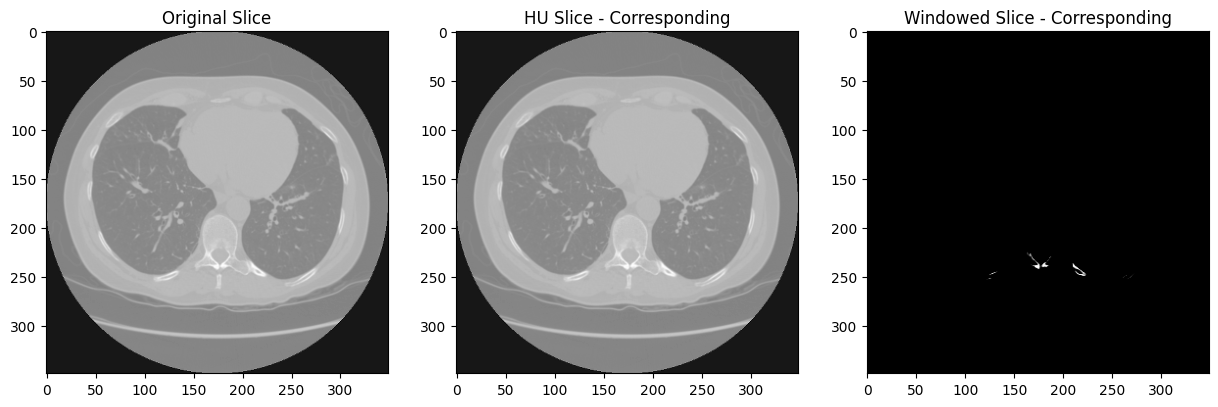

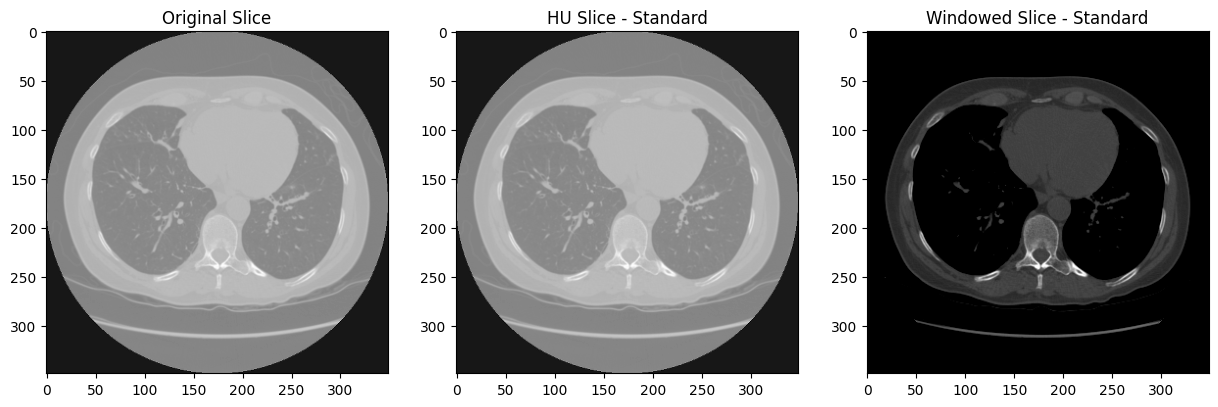

(321, 285, 285)
[-0450, -0450] [02000, 02000] -1000 1


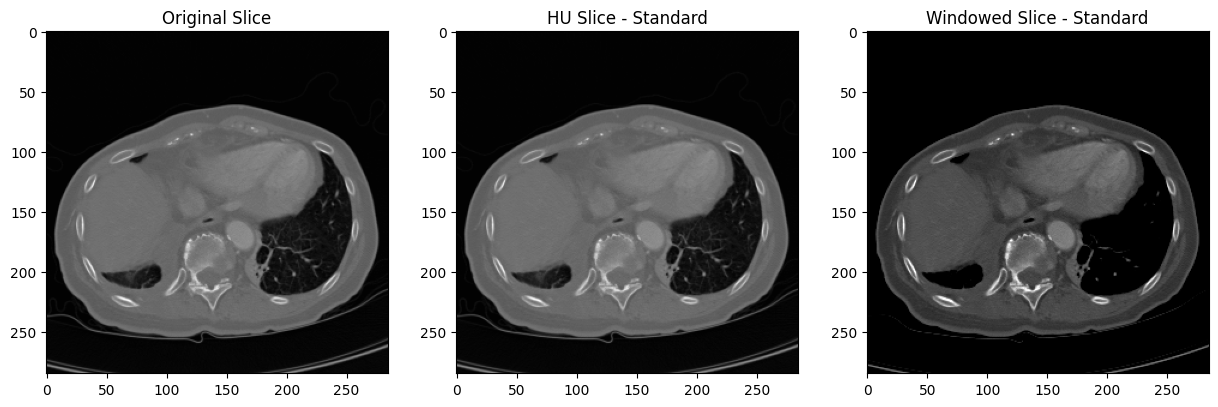

In [206]:
# pid 0002
pid = 'LIDC-IDRI-0002'
img, wc, wl, ri, rs = read_ct_scan2sitk(pid)
img_resampled = resample_img(img, standard_voxel_spacing)
shape = sitk.GetArrayFromImage(img_resampled).shape
print(shape)
print(wc, wl, ri, rs)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

_slice = sitk.GetArrayFromImage(img_resampled)[100]
ax[0].imshow(_slice, cmap='gray')
ax[0].set_title('Original Slice')

apply_window = transform_to_hu(ri, rs, _slice)
ax[1].imshow(apply_window, cmap='gray')
ax[1].set_title('HU Slice - Corresponding')

# apply windowing to the first slice
windowed = window_image(apply_window, wc, wl)
ax[2].imshow(windowed, cmap='gray')
ax[2].set_title('Windowed Slice - Corresponding')

plt.show()

# then use the standard options
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

_slice = sitk.GetArrayFromImage(img_resampled)[100]
ax[0].imshow(_slice, cmap='gray')
ax[0].set_title('Original Slice')

apply_window = transform_to_hu(ri, rs, _slice)
ax[1].imshow(apply_window, cmap='gray')
ax[1].set_title('HU Slice - Standard')

# apply windowing to the first slice
windowed = window_image(apply_window, standard_wc, standard_ww)
ax[2].imshow(windowed, cmap='gray')
ax[2].set_title('Windowed Slice - Standard')

plt.show()

# for pid 1002 and apply standard options
pid = 'LIDC-IDRI-1002'
img, wc, wl, ri, rs = read_ct_scan2sitk(pid)
img_resampled = resample_img(img, standard_voxel_spacing)
shape = sitk.GetArrayFromImage(img_resampled).shape
print(shape)
print(wc, wl, ri, rs)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

_slice = sitk.GetArrayFromImage(img_resampled)[100]
ax[0].imshow(_slice, cmap='gray')
ax[0].set_title('Original Slice')

apply_window = transform_to_hu(ri, rs, _slice)
ax[1].imshow(apply_window, cmap='gray')
ax[1].set_title('HU Slice - Standard')

# apply windowing to the first slice
windowed = window_image(apply_window, standard_wc, standard_ww)
ax[2].imshow(windowed, cmap='gray')
ax[2].set_title('Windowed Slice - Standard')

plt.show()

### Standard Transformation

Convert the volume to HU units with its own ri and rs, and then, apply the standard window level and window width.

***Standard lung window setting (width, 1600 HU; level, −600 HU)***. ==> Pulmonary Benign Ground-Glass Nodules: CT Features and Pathological Findings: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7930605/

***Window settings for evaluating the lung are window-width 1500 HU and window-level -600 HU.*** ==> Chest computed tomography display preferences. Survey of thoracic radiologists: https://pubmed.ncbi.nlm.nih.gov/8537208/

***Table 1*** states chest (lungs) intensity interval of $[600 \pm 1500/2]$. ==> Quick guide on radiology image pre-processing for deep learning applications in prostate cancer research: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7790158/


In [23]:
# advanced version inspired by the 2D above
def transform_scan2hu(itk_image, ri, rs):
    scan = sitk.GetArrayFromImage(itk_image)
    hu_scan = scan * rs + ri
    itk_hu_scan = sitk.GetImageFromArray(hu_scan)
    itk_hu_scan.CopyInformation(itk_image)
    return itk_hu_scan

def window_scan(itk_image, swc, sww):
    img_min = swc - sww // 2
    img_max = swc + sww // 2
    scan = sitk.GetArrayFromImage(itk_image)
    window_scan = scan.copy()
    window_scan[window_scan < img_min] = img_min
    window_scan[window_scan > img_max] = img_max
    itk_window_scan = sitk.GetImageFromArray(window_scan)
    itk_window_scan.CopyInformation(itk_image)
    return itk_window_scan

#### Visualization

Verified that the standard transformation defined above is correct.

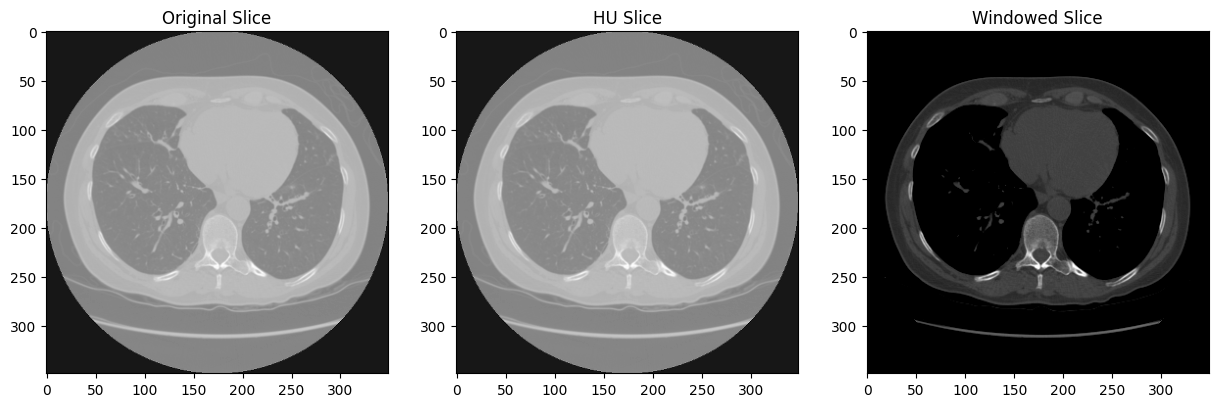

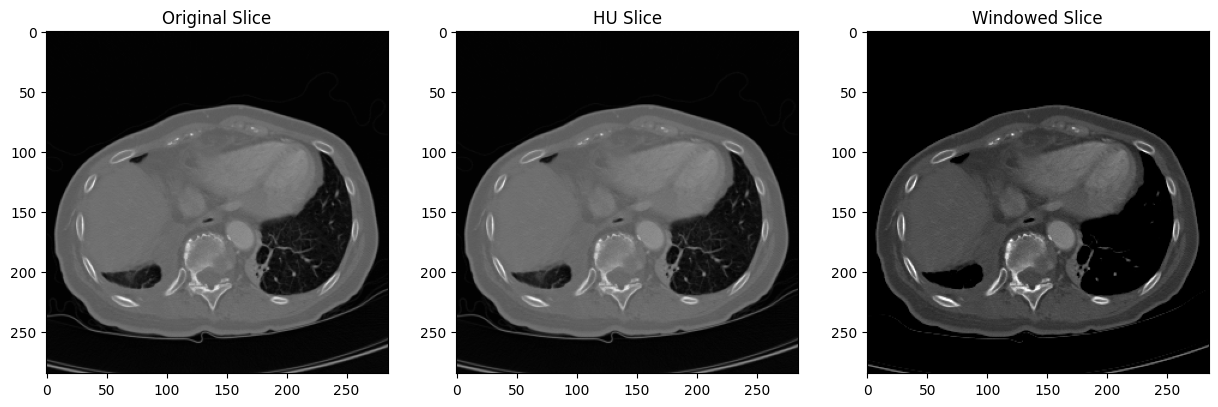

In [423]:
pid = 'LIDC-IDRI-0002'
img, wc, wl, ri, rs = read_ct_scan2sitk(pid)
img_resampled = resample_img(img, standard_voxel_spacing)

hu_scan = transform_scan2hu(img_resampled, ri, rs)
windowed_scan = window_scan(hu_scan, standard_wc, standard_ww)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# show original slice
ax[0].imshow(sitk.GetArrayFromImage(img_resampled)[100], cmap='gray')
ax[0].set_title('Original Slice')

# show hu slice
ax[1].imshow(sitk.GetArrayFromImage(hu_scan)[100], cmap='gray')
ax[1].set_title('HU Slice')

# show windowed slice
ax[2].imshow(sitk.GetArrayFromImage(windowed_scan)[100], cmap='gray')
ax[2].set_title('Windowed Slice')

plt.show()

pid = 'LIDC-IDRI-1002'
img, wc, wl, ri, rs = read_ct_scan2sitk(pid)
img_resampled = resample_img(img, standard_voxel_spacing)

hu_scan = transform_scan2hu(img_resampled, ri, rs)
windowed_scan = window_scan(hu_scan, standard_wc, standard_ww)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# show original slice
ax[0].imshow(sitk.GetArrayFromImage(img_resampled)[100], cmap='gray')
ax[0].set_title('Original Slice')

# show hu slice
ax[1].imshow(sitk.GetArrayFromImage(hu_scan)[100], cmap='gray')
ax[1].set_title('HU Slice')

# show windowed slice
ax[2].imshow(sitk.GetArrayFromImage(windowed_scan)[100], cmap='gray')
ax[2].set_title('Windowed Slice')

plt.show()

In [61]:
# apply on pid1
pid = 'LIDC-IDRI-0001'
img, wc, wl, ri, rs = read_ct_scan2sitk(pid)
img_resampled = resample_img(img, standard_voxel_spacing)

hu_scan = transform_scan2hu(img_resampled, -1024, 1)
windowed_scan = window_scan(hu_scan, standard_wc, standard_ww)

# save E:\master-thesis\preprocess\test-results
sitk.WriteImage(windowed_scan, 'E:/master-thesis/preprocess/test-results/windowed_image_pid1.nii.gz')

## Center Cropping

*Recall* "Denoising diffusion probabilistic models for 3D medical image generation" limits the resolution of 128 × 128 × 128 voxel

<u>*The images were center-cropped to dimensions of 320 × 320 × 320 voxels before being resized to 128 × 128 × 128 voxels. Images from all datasets were min–max normalized to the range of − 1 to 1.*</u>

<font color=red>***Question:** What is the center cropping? And do we need it, for what?*</font>

### Stats before Center Cropping

This is to see the resampled image shape for all the CT images.

In [ ]:
def verify_shape_after_resample():
    stats_shape_after_standard_resample = dict()
    
    scans = pl.query(pl.Scan).all()
    for scan in scans:
        pid = scan.patient_id
        img, _, _, _, _ = read_ct_scan2sitk(pid)
        original_shape = sitk.GetArrayFromImage(img).shape
        resampled_img = resample_img(img, standard_voxel_spacing)
        shape = sitk.GetArrayFromImage(resampled_img).shape
        print('pid: {} ==> original shape: {}, resampled shape: {}'.format(pid, original_shape, shape))
        print('orignal spacing: {}, resampled spacing: {}'.format(img.GetSpacing(), resampled_img.GetSpacing()))
        print('============================================================================================================')
        stats_shape_after_standard_resample[pid] = (img.GetSpacing(), original_shape, shape)
    
    # sort the stats by pid 
    stats_shape_after_standard_resample = dict(sorted(stats_shape_after_standard_resample.items()))

    # visualize the stats
    df = pd.DataFrame(stats_shape_after_standard_resample).T
    df.columns = ['Original Spacing', 'Original Shape', 'Resampled Shape']
    df.index.name = 'Patient ID'
    df.reset_index(inplace=True)

    return df

shape_stats_resample_df = verify_shape_after_resample()
shape_stats_resample_df.to_csv('shape_origin_and_resample.csv', index=False)

#### Visualization

Explained why 320 slices are chosen, it could be due to the fact that its mean slice number is 319.5.

Regarding the (X, Y, _), the original is 512x512, and the resampled mean is 352.28.

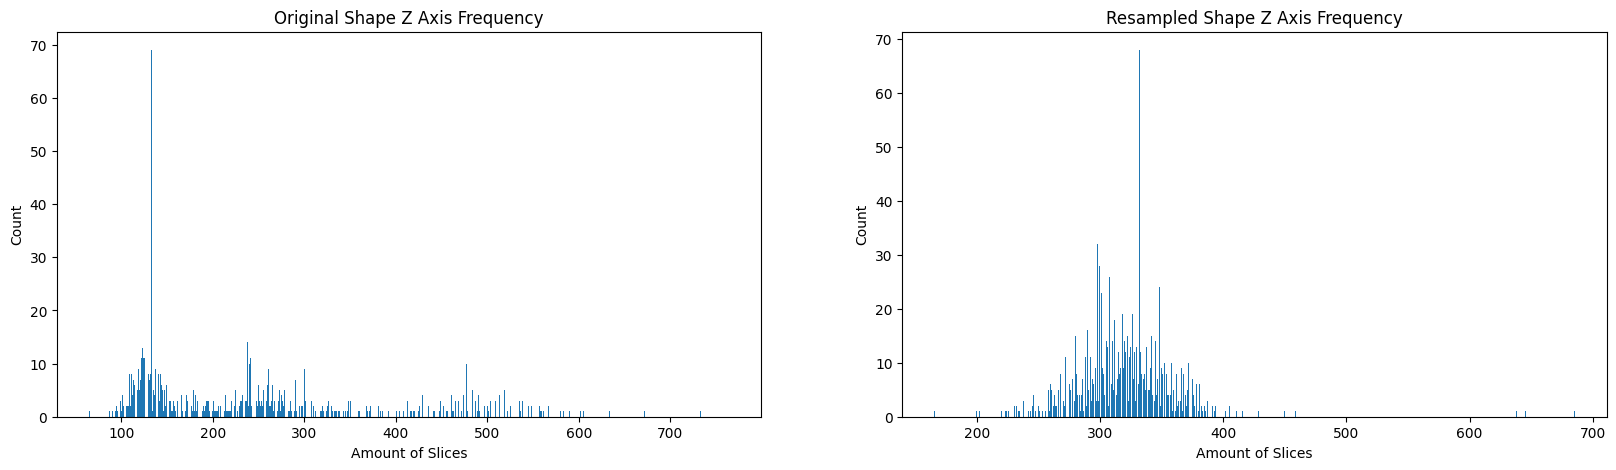

Most Common Slice Amount (Before/After): 133 332
Mean Slice Amount (Before/After): 240.47821782178218 319.86534653465344


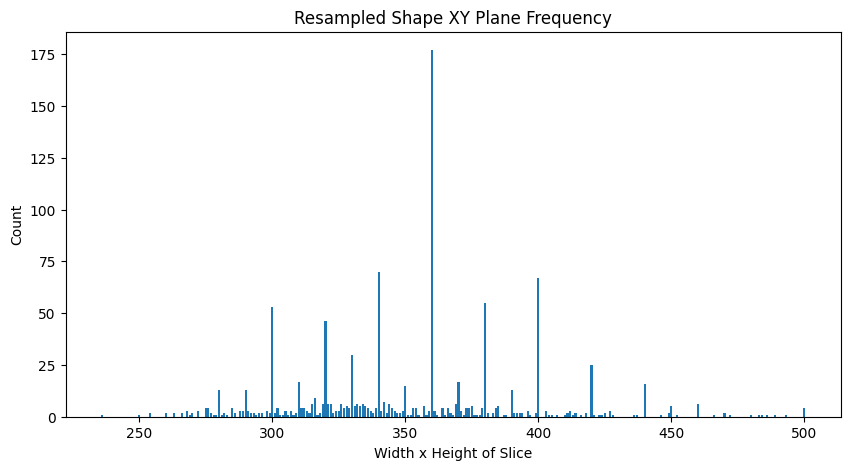

Mean Width x Height of Slice (After): 352.28019801980196


In [343]:
# visualize the stats by matplotlib
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
z_shape = shape_stats_resample_df['Original Shape'].apply(lambda x: x[0])
z_shape_freq = z_shape.value_counts().sort_index()

ax[0].bar(z_shape_freq.index, z_shape_freq.values)
ax[0].set_title('Original Shape Z Axis Frequency')
ax[0].set_xlabel('Amount of Slices')
ax[0].set_ylabel('Count')

z_shape_resampled = shape_stats_resample_df['Resampled Shape'].apply(lambda x: x[0])
z_shape_resampled_freq = z_shape_resampled.value_counts().sort_index()
ax[1].bar(z_shape_resampled_freq.index, z_shape_resampled_freq.values)
ax[1].set_title('Resampled Shape Z Axis Frequency')
ax[1].set_xlabel('Amount of Slices')
ax[1].set_ylabel('Count')

plt.show()

# find the most common shape
print('Most Common Slice Amount (Before/After):', z_shape_freq.idxmax(), z_shape_resampled_freq.idxmax())
mean_of_z_shape = z_shape.mean()
mean_of_z_shape_resampled = z_shape_resampled.mean()
print('Mean Slice Amount (Before/After):', mean_of_z_shape, mean_of_z_shape_resampled)

# visualize the xy shape
xy_shape_resampled = shape_stats_resample_df['Resampled Shape'].apply(lambda x: x[1])
xy_shape_resampled_freq = xy_shape_resampled.value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(xy_shape_resampled_freq.index, xy_shape_resampled_freq.values)
plt.title('Resampled Shape XY Plane Frequency')
plt.xlabel('Width x Height of Slice')
plt.ylabel('Count')

plt.show()
mean_of_xy_shape_resampled = xy_shape_resampled.mean()
print('Mean Width x Height of Slice (After):', mean_of_xy_shape_resampled)

### Perform Center Crop

***Then, back to center crop. What is center crop?***

In 2D, from [cloudfactory of center crop](https://wiki.cloudfactory.com/docs/mp-wiki/augmentations/center-crop#:~:text=Let's%20jump%20in.-,Center%20Crop%20explained,central%20part%20of%20an%20image), it says this is a data augmentation technique that helps researchers to crop images to a specified height and width with a certain probability, and the key difference between Random Crop and Center Crop is that the latter crops the central part of an image. Besides, by [Keras](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/center_crop/#:~:text=CenterCrop%20class&text=A%20preprocessing%20layer%20which%20crops,matches%20the%20target%20aspect%20ratio), it referes to a preprocessing layer which crops images. The layer crops the central portion of the images to a target size. If an image is smaller than the target size, it will be resized and cropped so as to return the largest possible window in the image that matches the target aspect ratio. According to [PyTorch](https://pytorch.org/vision/0.17/generated/torchvision.transforms.CenterCrop.html), to put it simply, crops the given image at the center.

*Overall, center crop is to crop the central part of an image.*

Regarding 3D, [volumentations](https://github.com/ZFTurbo/volumentations) seems to provide a off-the-shelf solution for 3D center crop. However, I prefer more famous one, such as Torchio. <u>*First of all, what is the center crop for 3D images? For single slice, what will be done? Then, for the whole volume, what will be done?*</u>

Center-crop and Interpolation? ==> By GPT 3.5, normally, interpolation is no need when center cropping.

There are a lot of posts recommending Torchio library, for example, https://discuss.pytorch.org/t/data-agumentation-in-3d-images/86289. Based on the documentation, it said, "CropOrPad" transform modifies the affine matrix associated to the volume so that physical positions of the voxels are maintained. https://torchio.readthedocs.io/transforms/preprocessing.html#croporpad

<font color=red>***Here, in my master's thesis project, there is some questions that I would like to make sure in this secion. First, is it necessary to do this? And why this target shape? The way how to do is correct?***</font>

Anyway, below is the way how I perform center cropping by using TorchIO. (Deprecated since it does not support CenterCrop) By the way, in documentation, torchio clearly warns that the resizing which will be involved later should not be used. ==> In most medical image applications, this transform should not be used as it will deform the physical object by scaling anistropically along the different dimensions. The solution to change an image size is typically applying Resample and CropOrPad.

Now, I am going to use SimpleITK to perform center cropping.

My understanding now, is that in this step, crop the central of the xy plane and z direction. For the xy plane which is smaller than the target size, do padding. For the z direction, if the number of slices is smaller than the target size, do padding as well.

In [5]:
target_x = 320
target_y = 320
target_z = 320

In [6]:
def center_crop(itk_image, target_x, target_y, target_z):
    # center refers to the center of the image
    size = itk_image.GetSize()
    
    # check the z axis first
    if size[2] < target_z:
        # pad
        z_num_pad = target_z - size[2]
        # pad before and after
        z_pad_before = z_num_pad // 2
        z_pad_after = z_num_pad - z_pad_before
        pad_filter = sitk.ConstantPadImageFilter()
        value = itk_image.GetPixel([0, 0, 0])
        pad_filter.SetConstant(value)
        pad_filter.SetPadLowerBound([0, 0, z_pad_before])
        pad_filter.SetPadUpperBound([0, 0, z_pad_after])
        itk_image = pad_filter.Execute(itk_image)
        size = itk_image.GetSize()
        
    # check the x axis
    if size[0] < target_x or size[1] < target_y:
        # pad
        x_num_pad = target_x - size[0]
        y_num_pad = target_y - size[1]
        # pad before and after
        x_pad_before = x_num_pad // 2
        x_pad_after = x_num_pad - x_pad_before
        y_pad_before = y_num_pad // 2
        y_pad_after = y_num_pad - y_pad_before
        value = itk_image.GetPixel([0, 0, 0])
        pad_filter = sitk.ConstantPadImageFilter()
        pad_filter.SetConstant(value)
        pad_filter.SetPadLowerBound([x_pad_before, y_pad_before, 0])
        pad_filter.SetPadUpperBound([x_pad_after, y_pad_after, 0])
        itk_image = pad_filter.Execute(itk_image)        

    # get the new size
    size = itk_image.GetSize()
        
    # crop image to target size
    crop_filter = sitk.CropImageFilter()
    start_x = (size[0] - target_x) // 2 if size[0] > target_x else 0
    start_y = (size[1] - target_y) // 2 if size[1] > target_y else 0
    start_z = 0
    end_x = target_x
    end_y = target_y
    end_z = target_z
    # crop_filter.SetLowerBoundaryCropSize([size[0] - end_x, size[1] - end_y, size[2] - end_z]) this is incorrect for inplane
    # x y
    #crop_filter.SetUpperBoundaryCropSize([start_x, start_y, start_z])
    crop_filter.SetUpperBoundaryCropSize([start_x, start_y, start_z])
    crop_filter.SetLowerBoundaryCropSize([size[0] - end_x - start_x, size[1] - end_y - start_y, size[2] - end_z])
    
    return crop_filter.Execute(itk_image)

#### Visualization

Verified the center cropping is correct. It contains 3 cases, one is xy inplane is smaller than the target size, one is each direction is larger than the target size, and the last one is each direction is smaller than the target size.

And the very last one is to see the most common case.

*NB:* By experiments, if considering center cropping the z direction, the target size will not include all the lung info. --> see saved nii.gz files.

Therefore, z direction is not considered in the center cropping, but starting from the first slice and ending at the last given the target size.

Original Shape: (321, 285, 285)
Cropped Shape: (320, 320, 320)


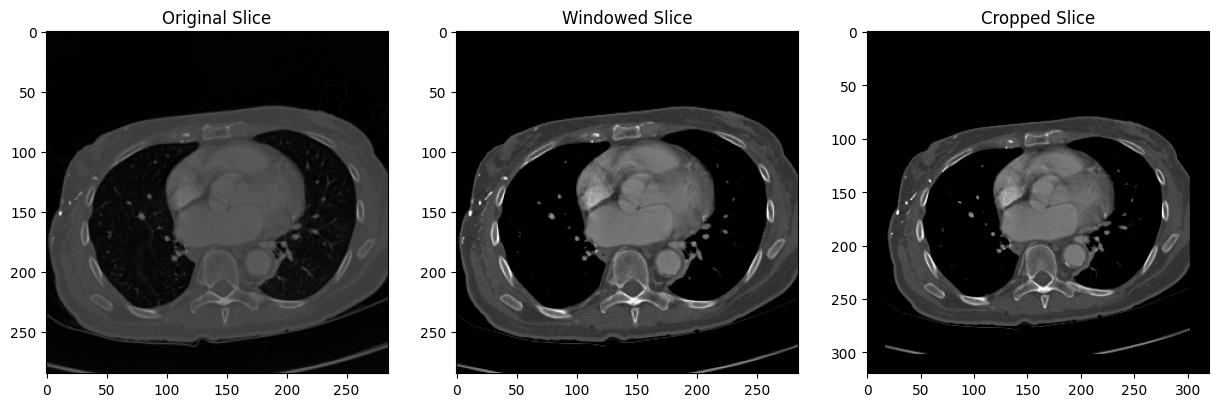

In [43]:
# case 1: inplane is smaller than target, but z is larger than target --> Done
pid = 'LIDC-IDRI-1002'
img, wc, wl, ri, rs = read_ct_scan2sitk(pid)
img_resampled = resample_img(img, standard_voxel_spacing)

hu_scan = transform_scan2hu(img_resampled, ri, rs)
windowed_scan = window_scan(hu_scan, standard_wc, standard_ww)

cropped_scan = center_crop(windowed_scan, target_x, target_y, target_z)

print('Original Shape:', sitk.GetArrayFromImage(windowed_scan).shape)
print('Cropped Shape:', sitk.GetArrayFromImage(cropped_scan).shape)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# central slice
ax[0].imshow(sitk.GetArrayFromImage(img_resampled)[159], cmap='gray')
ax[0].set_title('Original Slice')

# central slice
ax[1].imshow(sitk.GetArrayFromImage(windowed_scan)[159], cmap='gray')
ax[1].set_title('Windowed Slice')

# central slice
ax[2].imshow(sitk.GetArrayFromImage(cropped_scan)[159], cmap='gray')
ax[2].set_title('Cropped Slice')

plt.show()

Patient ID with the most slices: LIDC-IDRI-0509


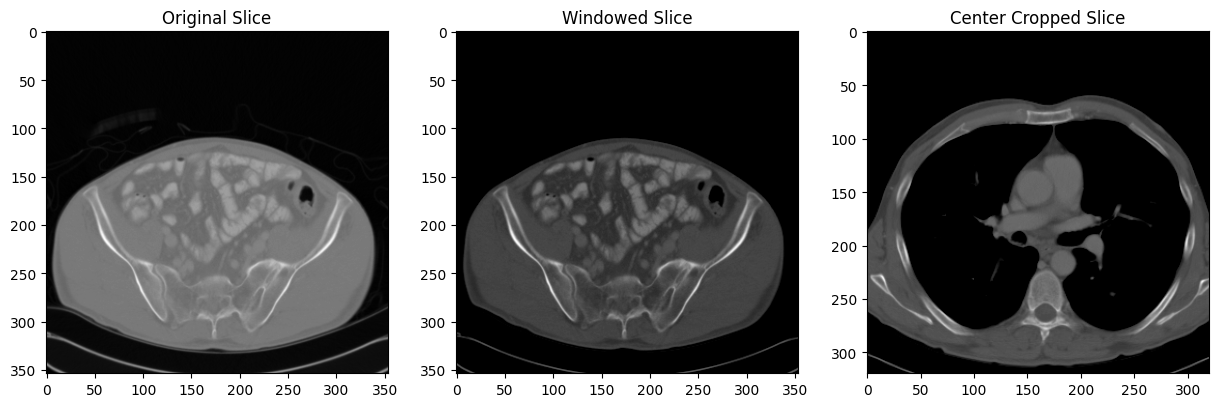

Original Shape: (685, 354, 354)
Windowed Shape: (685, 354, 354)
Center Cropped Shape: (320, 320, 320)


In [464]:
# case 2: each dimension is larger than target --> Done

# find pid with the most slices from shape_stats_resample_df -> pid stored in column 'Patient ID'
max_slices = shape_stats_resample_df['Resampled Shape'].apply(lambda x: x[0]).max()
max_slices_pid = shape_stats_resample_df[shape_stats_resample_df['Resampled Shape'].apply(lambda x: x[0]) == max_slices]['Patient ID'].values[0]
print('Patient ID with the most slices:', max_slices_pid)

pid = max_slices_pid
img, wc, wl, ri, rs = read_ct_scan2sitk(pid)
img_resampled = resample_img(img, standard_voxel_spacing)

hu_scan = transform_scan2hu(img_resampled, ri, rs)
windowed_scan = window_scan(hu_scan, standard_wc, standard_ww)

center_cropped = center_crop(windowed_scan, target_x, target_y, target_z)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# show original slice
ax[0].imshow(sitk.GetArrayFromImage(img_resampled)[160], cmap='gray')
ax[0].set_title('Original Slice')

# show windowed slice
ax[1].imshow(sitk.GetArrayFromImage(windowed_scan)[160], cmap='gray')
ax[1].set_title('Windowed Slice')

# show center cropped slice
ax[2].imshow(sitk.GetArrayFromImage(center_cropped)[160], cmap='gray')
ax[2].set_title('Center Cropped Slice')

plt.show()
print('Original Shape:', sitk.GetArrayFromImage(img_resampled).shape)
print('Windowed Shape:', sitk.GetArrayFromImage(windowed_scan).shape)
print('Center Cropped Shape:', sitk.GetArrayFromImage(center_cropped).shape)

# save the center cropped image
sitk.WriteImage(center_cropped, 'center_cropped_image_z_0.nii.gz')

Patient ID with the smallest shape: LIDC-IDRI-0403 Shape: (166, 254, 254)


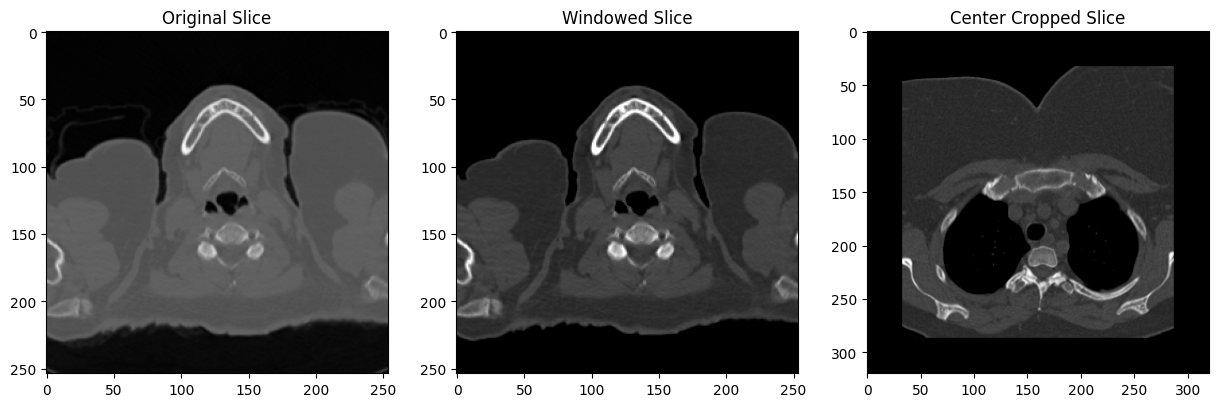

Original Shape: (166, 254, 254)
Windowed Shape: (166, 254, 254)
Center Cropped Shape: (320, 320, 320)


In [470]:
# case 3: xyz are smaller than target --> Done
# find the one with the smallest shape
min_shape = shape_stats_resample_df['Resampled Shape'].apply(lambda x: x[0] * x[1] * x[2]).min()
min_shape_pid = shape_stats_resample_df[shape_stats_resample_df['Resampled Shape'].apply(lambda x: x[0] * x[1] * x[2]) == min_shape]['Patient ID'].values[0]
print('Patient ID with the smallest shape:', min_shape_pid, 'Shape:', shape_stats_resample_df[shape_stats_resample_df['Patient ID'] == min_shape_pid]['Resampled Shape'].values[0])

pid = min_shape_pid
img, wc, wl, ri, rs = read_ct_scan2sitk(pid)
img_resampled = resample_img(img, standard_voxel_spacing)

hu_scan = transform_scan2hu(img_resampled, ri, rs)
windowed_scan = window_scan(hu_scan, standard_wc, standard_ww)

center_cropped = center_crop(windowed_scan, target_x, target_y, target_z)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# show original slice
ax[0].imshow(sitk.GetArrayFromImage(img_resampled)[160], cmap='gray')
ax[0].set_title('Original Slice')

# show windowed slice
ax[1].imshow(sitk.GetArrayFromImage(windowed_scan)[160], cmap='gray')
ax[1].set_title('Windowed Slice')

# show center cropped slice
ax[2].imshow(sitk.GetArrayFromImage(center_cropped)[160], cmap='gray')
ax[2].set_title('Center Cropped Slice')

plt.show()

print('Original Shape:', sitk.GetArrayFromImage(img_resampled).shape)
print('Windowed Shape:', sitk.GetArrayFromImage(windowed_scan).shape)
print('Center Cropped Shape:', sitk.GetArrayFromImage(center_cropped).shape)

# # save the center cropped image
# sitk.WriteImage(center_cropped, 'center_cropped_image_xyz.nii.gz')

Patient ID with the most common z: LIDC-IDRI-0001 Shape: (332, 360, 360)


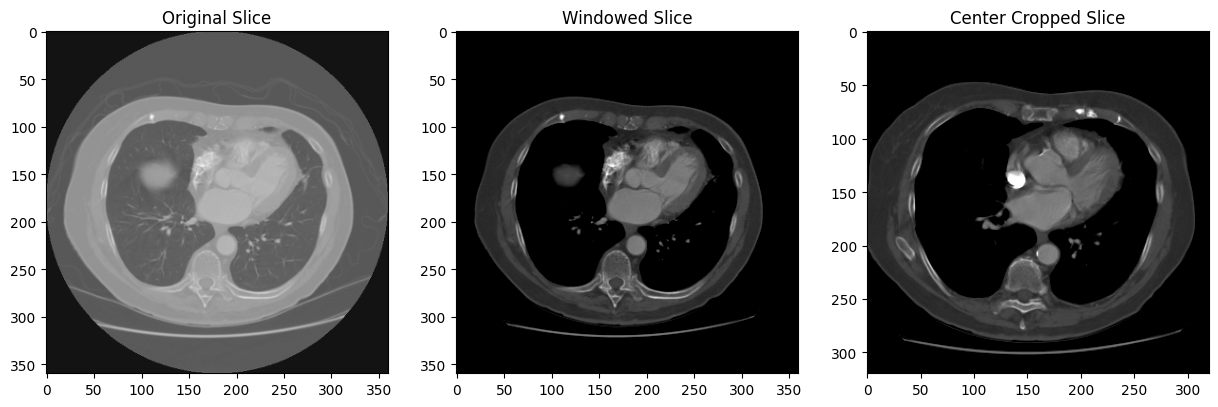

Original Shape: (332, 360, 360)
Windowed Shape: (332, 360, 360)
Center Cropped Shape: (320, 320, 320)


In [474]:
# case 4: z is the most common one
most_common_z = z_shape_resampled_freq.idxmax()

# find the pid with the most common z
most_common_z_pid = shape_stats_resample_df[shape_stats_resample_df['Resampled Shape'].apply(lambda x: x[0]) == most_common_z]['Patient ID'].values[0]
print('Patient ID with the most common z:', most_common_z_pid, 'Shape:', shape_stats_resample_df[shape_stats_resample_df['Patient ID'] == most_common_z_pid]['Resampled Shape'].values[0])

pid = most_common_z_pid
img, wc, wl, ri, rs = read_ct_scan2sitk(pid)
img_resampled = resample_img(img, standard_voxel_spacing)

hu_scan = transform_scan2hu(img_resampled, ri, rs)
windowed_scan = window_scan(hu_scan, standard_wc, standard_ww)

center_cropped = center_crop(windowed_scan, target_x, target_y, target_z)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# show original slice
ax[0].imshow(sitk.GetArrayFromImage(img_resampled)[160], cmap='gray')
ax[0].set_title('Original Slice')

# show windowed slice
ax[1].imshow(sitk.GetArrayFromImage(windowed_scan)[160], cmap='gray')
ax[1].set_title('Windowed Slice')

# show center cropped slice
ax[2].imshow(sitk.GetArrayFromImage(center_cropped)[160], cmap='gray')
ax[2].set_title('Center Cropped Slice')

plt.show()

print('Original Shape:', sitk.GetArrayFromImage(img_resampled).shape)
print('Windowed Shape:', sitk.GetArrayFromImage(windowed_scan).shape)
print('Center Cropped Shape:', sitk.GetArrayFromImage(center_cropped).shape)

# save the center cropped image
sitk.WriteImage(center_cropped, 'center_cropped_image_z_most_common.nii.gz')

## Resize

From the documentation provided by TorchIO, it is not recommended to apply `Resize` function built in itself, the reason is as follows: 

In most medical image applications, this transform should not be used as it will deform the physical object by scaling anistropically along the different dimensions. The solution to change an image size is typically applying `Resample` and `CropOrPad`.

Therefore, I am going to use `ResampleImageFilter()` from SimpleITK to perform resizing.

<font color=red>***Question**: Why $128\times 128 \times 128$ voxel is chosen?*</font>

In [6]:
reference_x = 128
reference_y = 128
reference_z = 128

In [7]:
# reference: https://stackoverflow.com/questions/48065117/simpleitk-resize-images
def resize2reference(sitk_image, reference_shape):
    size = sitk_image.GetSize()
    resample = sitk.ResampleImageFilter()
    # resample to the reference shape need new spacing calculated by the ratio of the size
    resample.SetOutputSpacing([size[0] / reference_shape[0], size[1] / reference_shape[1], size[2] / reference_shape[2]])
    resample.SetSize(reference_shape)
    resample.SetOutputDirection(sitk_image.GetDirection())
    resample.SetOutputOrigin(sitk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(sitk_image.GetPixelIDValue())
    resample.SetInterpolator(sitk.sitkBSpline)
    
    return resample.Execute(sitk_image)

### Visualization

Original Shape: (261, 512, 512)
Windowed Shape: (326, 349, 349)
Center Cropped Shape: (320, 320, 320)
Resized Shape: (128, 128, 128)


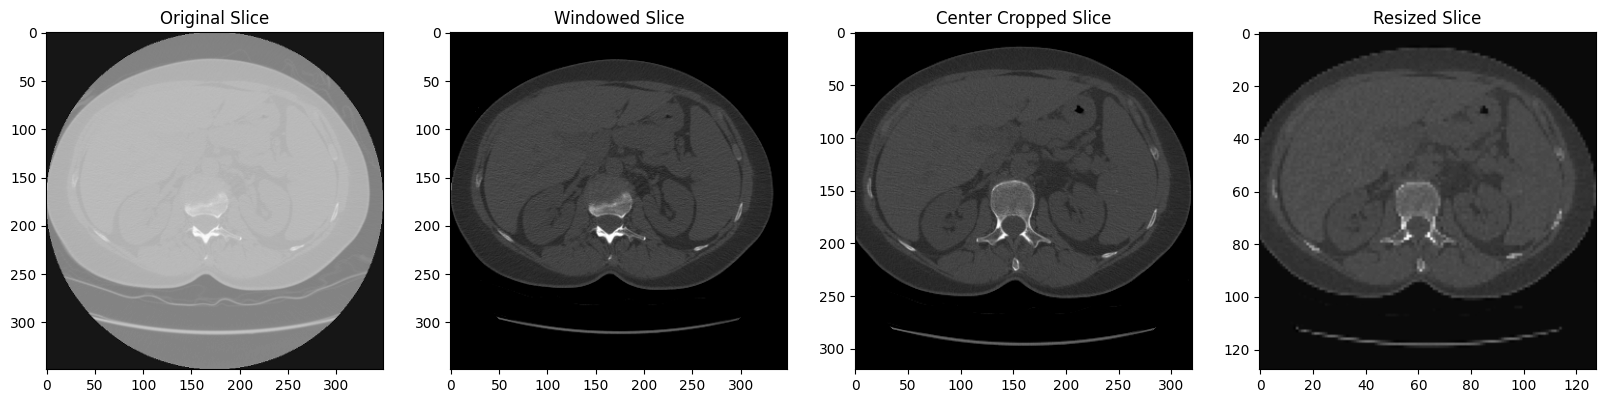

In [490]:
pid = 'LIDC-IDRI-0002'
img, wc, wl, ri, rs = read_ct_scan2sitk(pid)
img_resampled = resample_img(img, standard_voxel_spacing)

hu_scan = transform_scan2hu(img_resampled, ri, rs)
windowed_scan = window_scan(hu_scan, standard_wc, standard_ww)

center_cropped = center_crop(windowed_scan, target_x, target_y, target_z)
resized = resize2reference(center_cropped, [reference_x, reference_y, reference_z])

print('Original Shape:', sitk.GetArrayFromImage(img).shape)
print('Windowed Shape:', sitk.GetArrayFromImage(windowed_scan).shape)
print('Center Cropped Shape:', sitk.GetArrayFromImage(center_cropped).shape)
print('Resized Shape:', sitk.GetArrayFromImage(resized).shape)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# show original slice
ax[0].imshow(sitk.GetArrayFromImage(img_resampled)[0], cmap='gray')
ax[0].set_title('Original Slice')

# show windowed slice
ax[1].imshow(sitk.GetArrayFromImage(windowed_scan)[0], cmap='gray')
ax[1].set_title('Windowed Slice')

# show center cropped slice
ax[2].imshow(sitk.GetArrayFromImage(center_cropped)[0], cmap='gray')
ax[2].set_title('Center Cropped Slice')

# show resized slice
ax[3].imshow(sitk.GetArrayFromImage(resized)[0], cmap='gray')
ax[3].set_title('Resized Slice')

plt.show()

# # save the resized image
# sitk.WriteImage(resized, 'resized_image.nii.gz')

Original Shape: (133, 512, 512)
Windowed Shape: (332, 360, 360)
Center Cropped Shape: (320, 320, 320)
Resized Shape: (128, 128, 128)


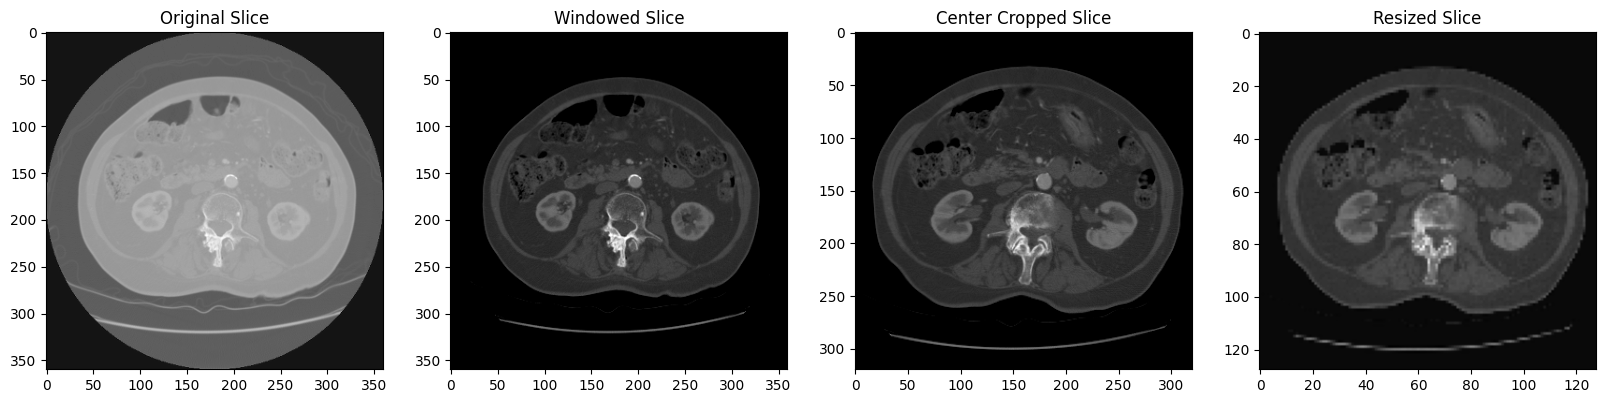

In [493]:
# try most common z
pid = most_common_z_pid
img, wc, wl, ri, rs = read_ct_scan2sitk(pid)
img_resampled = resample_img(img, standard_voxel_spacing)

hu_scan = transform_scan2hu(img_resampled, ri, rs)
windowed_scan = window_scan(hu_scan, standard_wc, standard_ww)

center_cropped = center_crop(windowed_scan, target_x, target_y, target_z)
resized = resize2reference(center_cropped, [reference_x, reference_y, reference_z])

print('Original Shape:', sitk.GetArrayFromImage(img).shape)
print('Windowed Shape:', sitk.GetArrayFromImage(windowed_scan).shape)
print('Center Cropped Shape:', sitk.GetArrayFromImage(center_cropped).shape)
print('Resized Shape:', sitk.GetArrayFromImage(resized).shape)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# show original slice
ax[0].imshow(sitk.GetArrayFromImage(img_resampled)[0], cmap='gray')
ax[0].set_title('Original Slice')

# show windowed slice
ax[1].imshow(sitk.GetArrayFromImage(windowed_scan)[0], cmap='gray')
ax[1].set_title('Windowed Slice')

# show center cropped slice
ax[2].imshow(sitk.GetArrayFromImage(center_cropped)[0], cmap='gray')
ax[2].set_title('Center Cropped Slice')

# show resized slice
ax[3].imshow(sitk.GetArrayFromImage(resized)[0], cmap='gray')
ax[3].set_title('Resized Slice')

plt.show()

# save the resized image
sitk.WriteImage(resized, 'resized_image_z_most_common.nii.gz')

Original Shape: (331, 512, 512)
Windowed Shape: (166, 254, 254)
Center Cropped Shape: (320, 320, 320)
Resized Shape: (128, 128, 128)


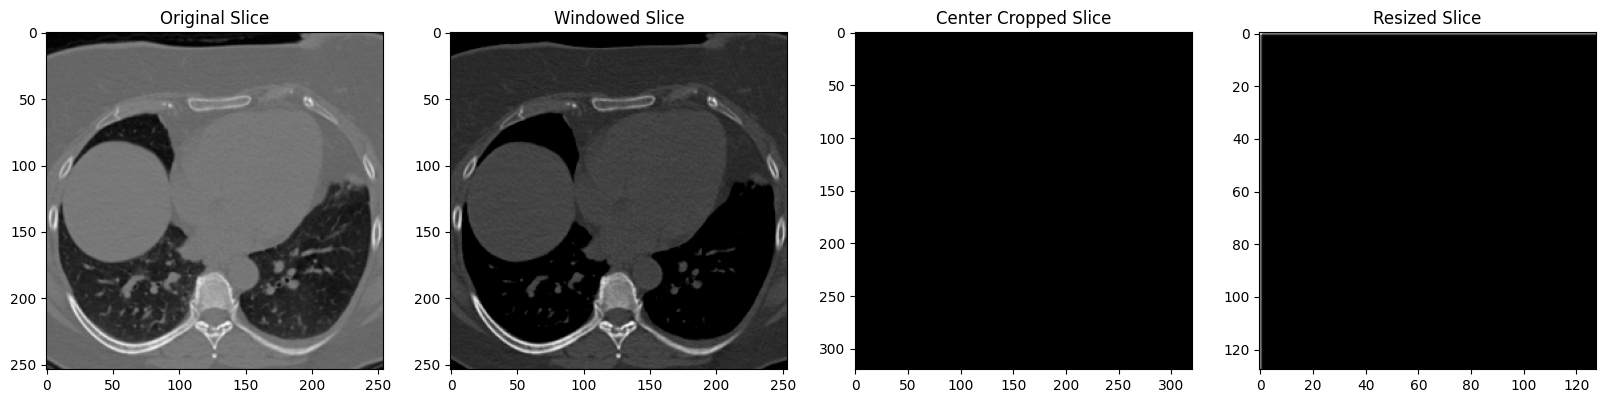

In [497]:
# try the smallest shape
pid = min_shape_pid
img, wc, wl, ri, rs = read_ct_scan2sitk(pid)

img_resampled = resample_img(img, standard_voxel_spacing)

hu_scan = transform_scan2hu(img_resampled, ri, rs)
windowed_scan = window_scan(hu_scan, standard_wc, standard_ww)

center_cropped = center_crop(windowed_scan, target_x, target_y, target_z)
resized = resize2reference(center_cropped, [reference_x, reference_y, reference_z])

print('Original Shape:', sitk.GetArrayFromImage(img).shape)
print('Windowed Shape:', sitk.GetArrayFromImage(windowed_scan).shape)
print('Center Cropped Shape:', sitk.GetArrayFromImage(center_cropped).shape)
print('Resized Shape:', sitk.GetArrayFromImage(resized).shape)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# show original slice
ax[0].imshow(sitk.GetArrayFromImage(img_resampled)[0], cmap='gray')
ax[0].set_title('Original Slice')

# show windowed slice
ax[1].imshow(sitk.GetArrayFromImage(windowed_scan)[0], cmap='gray')
ax[1].set_title('Windowed Slice')

# show center cropped slice
ax[2].imshow(sitk.GetArrayFromImage(center_cropped)[0], cmap='gray')
ax[2].set_title('Center Cropped Slice')

# show resized slice
ax[3].imshow(sitk.GetArrayFromImage(resized)[0], cmap='gray')
ax[3].set_title('Resized Slice')

plt.show()

# # save the resized image
# sitk.WriteImage(resized, 'resized_image_smallest_shape.nii.gz')

## Normalization

Finally, come to normalization step.

By the paper, "Quick guide on radiology image pre-processing for deep learning applications in prostate cancer research", it states that we use a linear transformation, enforcing two critical points (smallest and largest values) to be mapped to (0, 255). A simple rule of thumb for implementing this is to use the windowing cut-off values of $W_L \pm W_W/2$ as the image extremes.

By the paper, "Preparing CT imaging datasets for deep learning: A survey", it states that the most common normalization method is to normalize the pixel values to the range of [0, 1] or [−1, 1]. ==> The reason is not only for the sake of the model, but also for the sake of the optimization algorithm. ==> speed up the gradient descent process to converge faster.

From the documentation, "Matlab Medical Image Processing Toolbox", it says first to clip intensities to a smaller range, and then normalize the clipped intensity range to the range of the image data type. ==> It seems that I have already performed clip by windowing and for CT it should be sufficient, however, I still want to normalize it to the range of [-1, 1] or [0, 1].

<font color=red>***Question**: Which range should I choose, and why?*</font>

How to normalize between -1 and 1?: https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1

Should input images be normalized to -1 to 1 or 0 to 1: https://datascience.stackexchange.com/questions/54296/should-input-images-be-normalized-to-1-to-1-or-0-to-1

In [8]:
def normalize2pm1(sitk_image):
    # normalize to [-1, 1]
    img = sitk.GetArrayFromImage(sitk_image)
    img = (img - img.min()) / (img.max() - img.min())
    img = img * 2 - 1
    itk_normalized = sitk.GetImageFromArray(img)
    itk_normalized.CopyInformation(sitk_image)
    
    return itk_normalized

### Visualization

Original Intensity -3677 1690
HU Intensity -4701.0 666.0
Windowed Intensity -1400.0 200.0
Center Cropped Intensity -1400.0 200.0
Resized Intensity -1512.2825475668799 331.71102176678795
Normalized Intensity -1.0 1.0


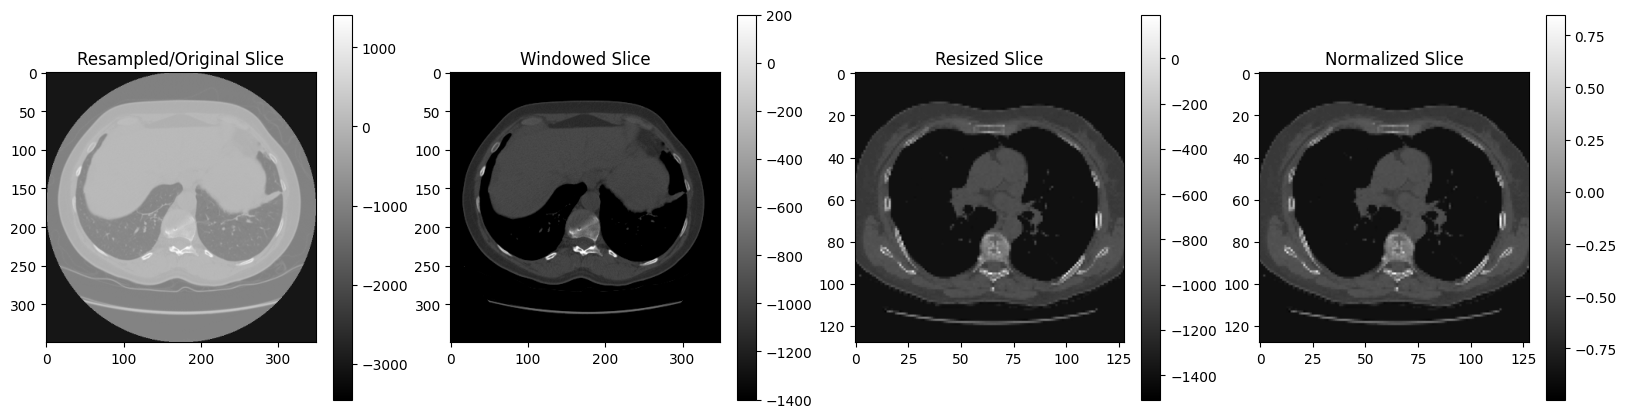

In [524]:
pid = 'LIDC-IDRI-0002'
img, wc, wl, ri, rs = read_ct_scan2sitk(pid)
img_resampled = resample_img(img, standard_voxel_spacing)
hu_scan = transform_scan2hu(img_resampled, ri, rs)
windowed_scan = window_scan(hu_scan, standard_wc, standard_ww)
center_cropped = center_crop(windowed_scan, target_x, target_y, target_z)
resized = resize2reference(center_cropped, [reference_x, reference_y, reference_z])
normalized = normalize2pm1(resized)

print('Original Intensity', sitk.GetArrayFromImage(img_resampled).min(), sitk.GetArrayFromImage(img_resampled).max())
print('HU Intensity', sitk.GetArrayFromImage(hu_scan).min(), sitk.GetArrayFromImage(hu_scan).max())
print('Windowed Intensity', sitk.GetArrayFromImage(windowed_scan).min(), sitk.GetArrayFromImage(windowed_scan).max())
print('Center Cropped Intensity', sitk.GetArrayFromImage(center_cropped).min(), sitk.GetArrayFromImage(center_cropped).max())
print('Resized Intensity', sitk.GetArrayFromImage(resized).min(), sitk.GetArrayFromImage(resized).max())
print('Normalized Intensity', sitk.GetArrayFromImage(normalized).min(), sitk.GetArrayFromImage(normalized).max())
    
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# show original, windowed, resized and normalized slice
ax[0].imshow(sitk.GetArrayFromImage(img_resampled)[64], cmap='gray')
ax[0].set_title('Resampled/Original Slice')
cbar = plt.colorbar(ax[0].imshow(sitk.GetArrayFromImage(img_resampled)[64], cmap='gray'), ax=ax[0])

ax[1].imshow(sitk.GetArrayFromImage(windowed_scan)[64], cmap='gray')
ax[1].set_title('Windowed Slice')
cbar = plt.colorbar(ax[1].imshow(sitk.GetArrayFromImage(windowed_scan)[64], cmap='gray'), ax=ax[1])

ax[2].imshow(sitk.GetArrayFromImage(resized)[0], cmap='gray')
ax[2].set_title('Resized Slice')
cbar = plt.colorbar(ax[2].imshow(sitk.GetArrayFromImage(resized)[64], cmap='gray'), ax=ax[2])

ax[3].imshow(sitk.GetArrayFromImage(normalized)[0], cmap='gray')
ax[3].set_title('Normalized Slice')
cbar = plt.colorbar(ax[3].imshow(sitk.GetArrayFromImage(normalized)[64], cmap='gray'), ax=ax[3])

plt.show()

# save the normalized image
sitk.WriteImage(normalized, 'normalized_image.nii.gz')

Original Intensity -2457 3823
HU Intensity -3481.0 2799.0
Windowed Intensity -1400.0 200.0
Center Cropped Intensity -1400.0 200.0
Resized Intensity -1560.767494144215 433.01019135769553
Normalized Intensity -1.0 1.0


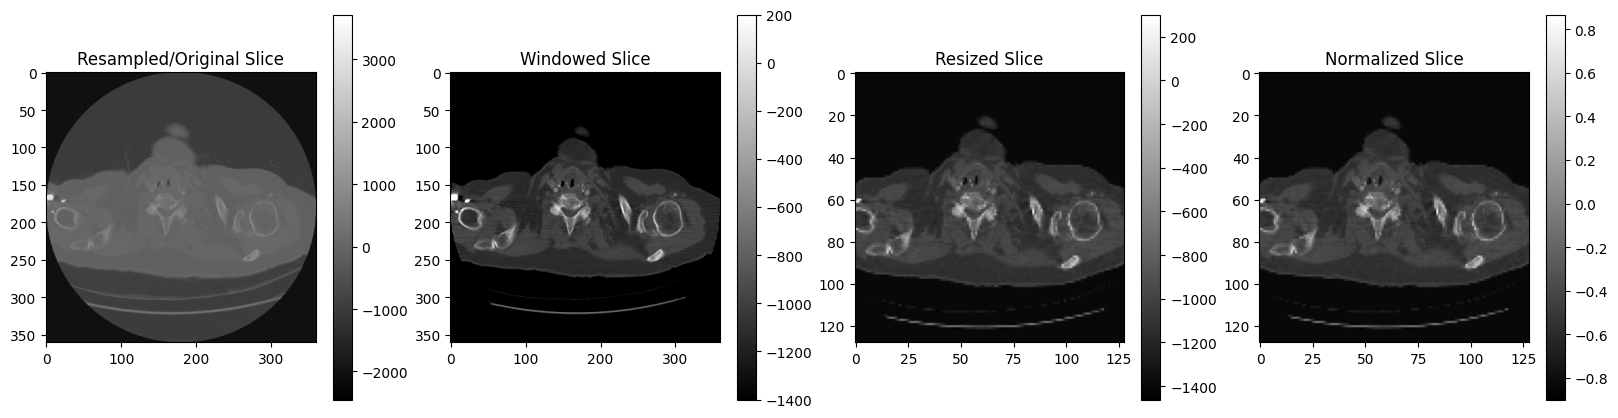

In [514]:
# try the most common z
pid = most_common_z_pid
img, wc, wl, ri, rs = read_ct_scan2sitk(pid)
img_resampled = resample_img(img, standard_voxel_spacing)
hu_scan = transform_scan2hu(img_resampled, ri, rs)
windowed_scan = window_scan(hu_scan, standard_wc, standard_ww)
center_cropped = center_crop(windowed_scan, target_x, target_y, target_z)
resized = resize2reference(center_cropped, [reference_x, reference_y, reference_z])
normalized = normalize2pm1(resized)

print('Original Intensity', sitk.GetArrayFromImage(img_resampled).min(), sitk.GetArrayFromImage(img_resampled).max())
print('HU Intensity', sitk.GetArrayFromImage(hu_scan).min(), sitk.GetArrayFromImage(hu_scan).max())
print('Windowed Intensity', sitk.GetArrayFromImage(windowed_scan).min(), sitk.GetArrayFromImage(windowed_scan).max())
print('Center Cropped Intensity', sitk.GetArrayFromImage(center_cropped).min(), sitk.GetArrayFromImage(center_cropped).max())
print('Resized Intensity', sitk.GetArrayFromImage(resized).min(), sitk.GetArrayFromImage(resized).max())
print('Normalized Intensity', sitk.GetArrayFromImage(normalized).min(), sitk.GetArrayFromImage(normalized).max())

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# show original, windowed, resized and normalized slice
ax[0].imshow(sitk.GetArrayFromImage(img_resampled)[-1], cmap='gray')
ax[0].set_title('Resampled/Original Slice')
cbar = plt.colorbar(ax[0].imshow(sitk.GetArrayFromImage(img_resampled)[-1], cmap='gray'), ax=ax[0])

ax[1].imshow(sitk.GetArrayFromImage(windowed_scan)[64], cmap='gray')
ax[1].set_title('Windowed Slice')
cbar = plt.colorbar(ax[1].imshow(sitk.GetArrayFromImage(windowed_scan)[-1], cmap='gray'), ax=ax[1])

ax[2].imshow(sitk.GetArrayFromImage(resized)[0], cmap='gray')
ax[2].set_title('Resized Slice')
cbar = plt.colorbar(ax[2].imshow(sitk.GetArrayFromImage(resized)[-1], cmap='gray'), ax=ax[2])

ax[3].imshow(sitk.GetArrayFromImage(normalized)[0], cmap='gray')
ax[3].set_title('Normalized Slice')
cbar = plt.colorbar(ax[3].imshow(sitk.GetArrayFromImage(normalized)[-1], cmap='gray'), ax=ax[3])

plt.show()

## CenterCropped In Use

#### Demo

In [9]:
# apply the steps until the downsample step for first 10 patients, save the results in the folder E:\master-thesis\methods\demo_center_cropped
pids = ['LIDC-IDRI-{:04d}'.format(i+1) for i in range(10)]
for pid in pids:
    img, wc, wl, ri, rs = read_ct_scan2sitk(pid)
    img_resampled = resample_img(img, standard_voxel_spacing)
    hu_scan = transform_scan2hu(img_resampled, ri, rs)
    windowed_scan = window_scan(hu_scan, standard_wc, standard_ww)
    center_cropped = center_crop(windowed_scan, target_x, target_y, target_z)
    sitk.WriteImage(center_cropped, 'E:\\master-thesis\\methods\\demo_center_cropped\\{}_center_cropped.nii.gz'.format(pid))
    print('Saved:', pid, 'Shape:', sitk.GetArrayFromImage(center_cropped).shape)

Saved: LIDC-IDRI-0001 Shape: (320, 320, 320)
Saved: LIDC-IDRI-0002 Shape: (320, 320, 320)
Saved: LIDC-IDRI-0003 Shape: (320, 320, 320)
Saved: LIDC-IDRI-0004 Shape: (320, 320, 320)
Saved: LIDC-IDRI-0005 Shape: (320, 320, 320)
Saved: LIDC-IDRI-0006 Shape: (320, 320, 320)
Saved: LIDC-IDRI-0007 Shape: (320, 320, 320)
Saved: LIDC-IDRI-0008 Shape: (320, 320, 320)
Saved: LIDC-IDRI-0009 Shape: (320, 320, 320)
Saved: LIDC-IDRI-0010 Shape: (320, 320, 320)


#### Real

In [36]:
def ct_scan2sitk(pl_scan):
    dcm_files = pl_scan.load_all_dicom_images()
    # read as sitk image
    reader = sitk.ImageSeriesReader()
    dicom_names = [dcm_files[i].filename for i in range(len(dcm_files))]
    reader.SetFileNames(dicom_names)
    # header to retrieve basic info
    header = dcm_files[0]
    window_center = header.WindowCenter
    window_width = header.WindowWidth
    rescale_intercept = header.RescaleIntercept
    rescale_slope = header.RescaleSlope
    
    return reader.Execute(), window_center, window_width, rescale_intercept, rescale_slope

In [48]:
# apply the steps until the downsample step for all scans, save the results in the folder E:\master-thesis\methods\demo_center_cropped
scans = pl.query(pl.Scan).all()
for i, scan in enumerate(scans):
    sitk_image, wc, wl, ri, rs = ct_scan2sitk(scan)
    img_resampled = resample_img(sitk_image, standard_voxel_spacing)
    hu_scan = transform_scan2hu(img_resampled, standard_ri, standard_rs)
    windowed_scan = window_scan(hu_scan, standard_wc, standard_ww)
    center_cropped = center_crop(windowed_scan, target_x, target_y, target_z)
    sitk.WriteImage(center_cropped, 'E:\\master-thesis\\methods\\center_cropped\\scan-{}.nii.gz'.format(scan.id))
print('Done')

Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a 

##### Note

By doing this, we found that some scan does not provide useful ri and rs, and giving the standard ri and rs is better

Loading dicom files ... This may take a moment.
Original Shape: (261, 333, 333)
HU Shape: (261, 333, 333)
Windowed Shape: (261, 333, 333)


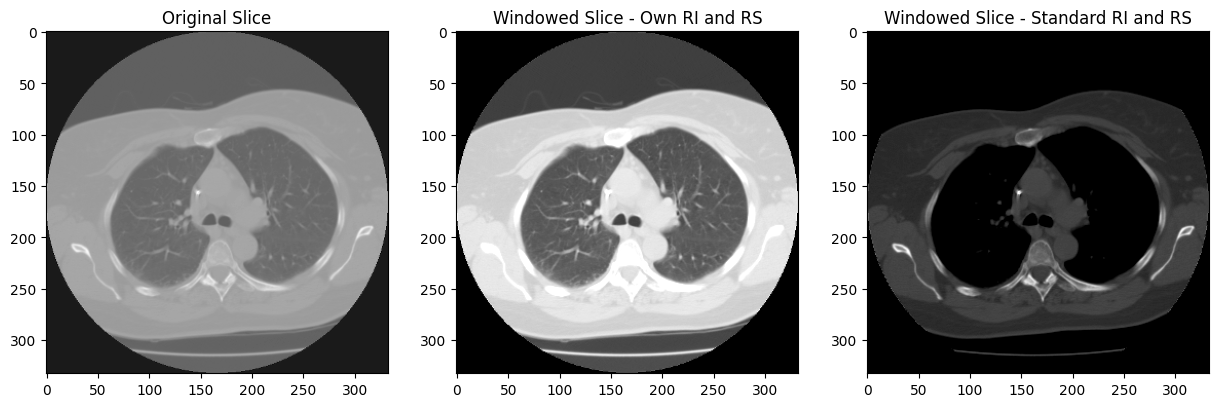

In [58]:
demo_scan = scans[0]
sitk_image, wc, wl, ri, rs = ct_scan2sitk(demo_scan)
img_resampled = resample_img(sitk_image, standard_voxel_spacing)
# make a comparison, standard ri and rs v.s. the original ri and rs
hu_scan_temp = transform_scan2hu(img_resampled, ri, rs)
windowed_scan_temp = window_scan(hu_scan_temp, standard_wc, standard_ww)

hu_scan = transform_scan2hu(img_resampled, standard_ri, standard_rs)
windowed_scan = window_scan(hu_scan, standard_wc, standard_ww)
print('Original Shape:', sitk.GetArrayFromImage(img_resampled).shape)
print('HU Shape:', sitk.GetArrayFromImage(hu_scan).shape)
print('Windowed Shape:', sitk.GetArrayFromImage(windowed_scan).shape)

# show original, windowed, and windowed with standard ri and rs side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# original
ax[0].title.set_text('Original Slice')
ax[0].imshow(sitk.GetArrayFromImage(img_resampled)[160], cmap='gray')

ax[1].title.set_text('Windowed Slice - Own RI and RS')
ax[1].imshow(sitk.GetArrayFromImage(windowed_scan_temp)[160], cmap='gray')

ax[2].title.set_text('Windowed Slice - Standard RI and RS')
ax[2].imshow(sitk.GetArrayFromImage(windowed_scan)[160], cmap='gray')

plt.show()

## Google Drive

Once the steps are confirmed by my superviser Prof. Jens Petersen, all the images will be preprocessed and saved in Google Drive.

Has been confirmed, and the cell centercropped in use is the preprocessed steps for all the images.

All the CT scans after preprocessing (Standard Resample, HU Conversion, Windowed, and Center Cropped) have been saved into the folder `E:\master-thesis\methods\center_cropped`.

This section is to zip these files and upload them to Google Drive.

In [59]:
import shutil

In [60]:
preprocessed_ct_folder_path = 'E:\\master-thesis\\methods\\center_cropped'
zipped_preprocessed_ct_folder_path = 'E:\\master-thesis\\methods\\center_cropped.zip'
shutil.make_archive(preprocessed_ct_folder_path, 'zip', preprocessed_ct_folder_path)
print('Done')

Done


In [ ]:
# unzip the folder and extract the content to the folder path_to_unzip
path_zipped = '/content/drive/master-thesis/brand-new/center_cropped.zip'
path_to_unzip = '/content/drive/master-thesis/brand-new/LIDC-IDRI-center-cropped'
shutil.unpack_archive(zipped_preprocessed_ct_folder_path, path_to_unzip, 'zip') # unzip the folder, the last argument is the format of the zipped file